# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [2]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [3]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [2]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
IP = "172.26.3.35"
port = 443
url = f"http://{IP}:{port}"

design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
stl_tess = Tesseract.from_url(url)
# stt_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [44]:
Nx, Ny, Nz = 250, 200, 20
Lx, Ly, Lz = 50, 40, 4

grid_fin_params = {
    "angular_positions": jnp.array(
        [
            [0, 3.14],
            [0.39, 3.53],
            [0.79, 3.93],
            [1.18, 4.32],
            [1.57, 4.71],
            [1.96, 5.11],
            [2.36, 5.50],
            [2.75, 5.89],
        ]
    ),
    "plane_height": 800,
    "plane_thickness": 100,
    "cuttin_plane_1": 400,
    "cuttin_plane_2": 400,
}

# lets create a flat parameter array from the grid fin params
init_diffable_params = jnp.concatenate(
    [
        jnp.array(
            [grid_fin_params["cuttin_plane_1"], grid_fin_params["cuttin_plane_2"]]
        ),
        grid_fin_params["angular_positions"].flatten(),
    ]
).astype(jnp.float32)

normalization_factors = 1 / jnp.array([1000, 1000] + [3.14 * 2] * 16, dtype=jnp.float32)
normalization_bias = jnp.zeros_like(normalization_factors)


def normalize(params, norms, bias):
    return params * norms + bias


def denormalize(params, norms, bias):
    return (params - bias) / norms


init_diffable_params = normalize(
    init_diffable_params, normalization_factors, normalization_bias
)

non_diffable_paramas = jnp.array(
    [
        grid_fin_params["plane_height"],
        grid_fin_params["plane_thickness"],
    ],
    dtype=jnp.float32,
)

design_inputs = {
    "non_differentiable_parameters": non_diffable_paramas,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "static_parameters": [],
    "string_parameters": [
        "F:\\ANSYS Inc\\v242\\scdm\\SpaceClaim.exe",
        "geometry_generation.scscript",
    ],
    "mesh_tesseract": TesseractReference(stl_tess),
    "grid_center": [0.0, 0.0, 2.0],
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "scale_mesh": 0.01,
    "max_points": 1000,
    "max_faces": 2000,
    "precompute_jacobian": True,
    "normalize_jacobian": True,
    "epsilon": 0.001,
}

print(init_diffable_params)

[0.4        0.4        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


In [49]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": init_diffable_params,
        **design_inputs,
    },
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

Starting Jacobian precomputation thread...
Number of vertices: 248
Number of faces: 564


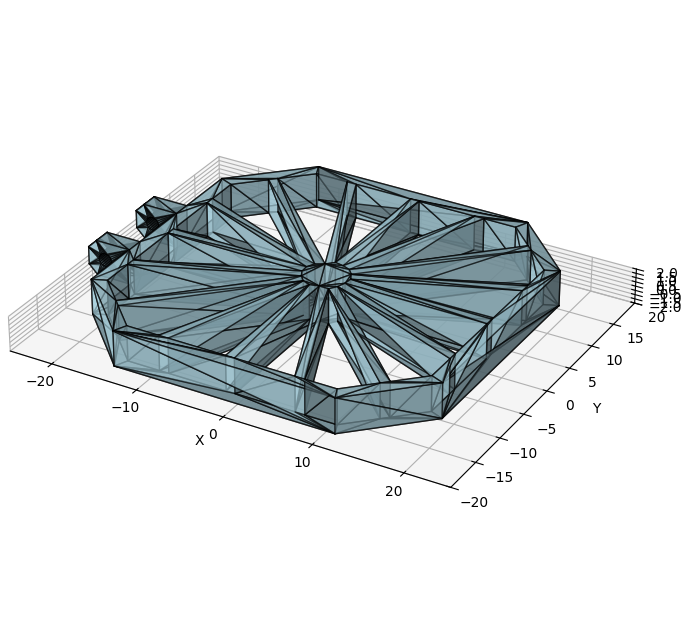

In [50]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # set equal aspect ratio
    ax.set_box_aspect(
        (
            (Lx) / (Ly),
            1,
            (Lz) / (Ly),
        )
    )

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

In [51]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-2, -0.5, 5)
# print(epsilons)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]
#     print(eps)
#     design_inputs_eps = design_inputs.copy()
#     design_inputs_eps["epsilon"] = eps.item()

#     primal, vjp_fun = jax.vjp(
#         lambda params, design_params=design_inputs_eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params,
#                 **design_params,
#             },
#         )["sdf"],
#         init_diffable_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [52]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

In [53]:
# primal, vjp_fun = jax.vjp(
#     lambda params: apply_tesseract(
#         design_tess,
#         {
#             "differentiable_parameters": params,
#             **design_inputs,
#         },
#     )["sdf"],
#     init_diffable_params,
# )

# grad = vjp_fun(jax.numpy.ones((Nx, Ny, Nz), dtype=jax.numpy.float32))[0]

# print("Gradient shape:", grad.shape)

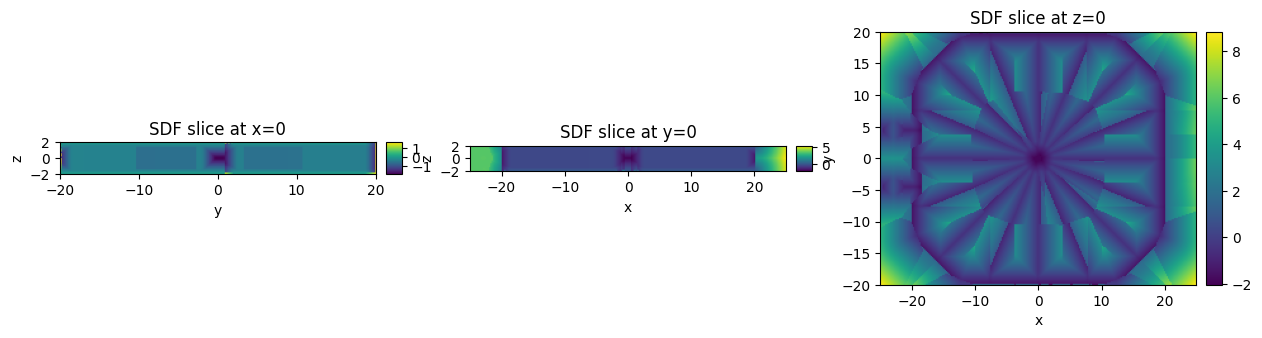

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

rho min: 1.2900221918243915e-05, rho max: 0.9936302304267883


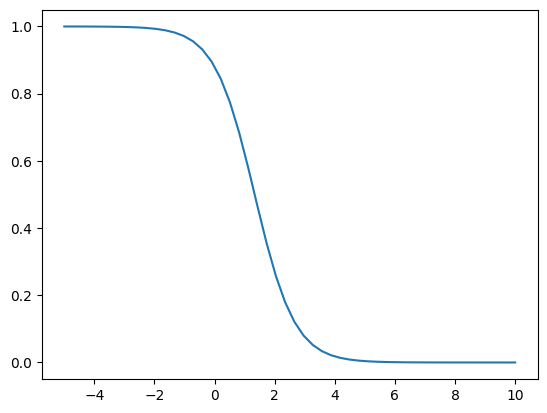

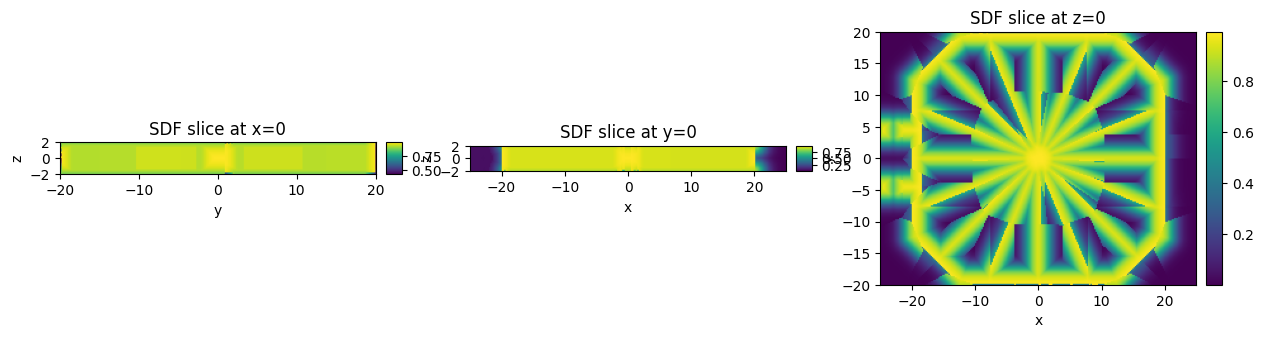

In [55]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 1.5
rho_offset = 2

# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)


rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.390625, max: 6.25


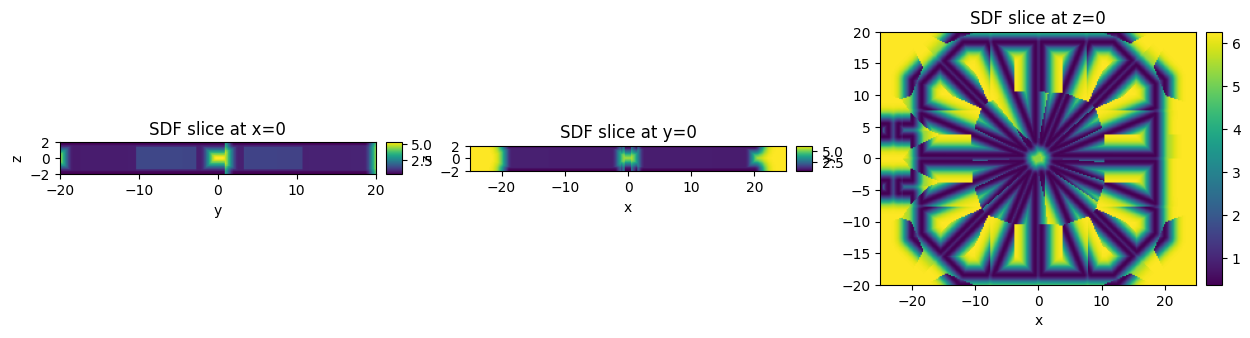

In [56]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 128
sizing_max = Lx / 8
sizing_scale = 1

sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

In [57]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        # "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
        "sizing_field": jnp.ones_like(sdf) * sizing_min,
        "field_values": rho,
        "max_subdivision_levels": 5,
        "max_points": 40000,
        "max_cells": 40000,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

Mesh points: 5445, Mesh faces: 4096


In [ ]:
# Lets export it to a .vtk using pyvista


def hex_to_pyvista(
    pts: jax.typing.ArrayLike, faces: jax.typing.ArrayLike, cell_data: dict
) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).
        cell_data: additional cell center data.

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    pts = np.array(pts)
    faces = np.array(faces)

    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    mesh = pv.UnstructuredGrid(cells, cell_types, pts)

    # Add cell data
    for name, data in cell_data.items():
        mesh.cell_data[name] = data

    return mesh


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"])
cells_np = np.array(adaptive_mesh["faces"])

hex_mesh = hex_to_pyvista(pts_np, cells_np, {"rho": mesher_out["mesh_cell_values"]})

print(hex_mesh)

hex_mesh.save("fem_shapeopt_mesh.vtk")

UnstructuredGrid (0x749784d4fa60)
  N Cells:    40000
  N Points:   40000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -2.000e+00, 2.000e+00
  N Arrays:   1


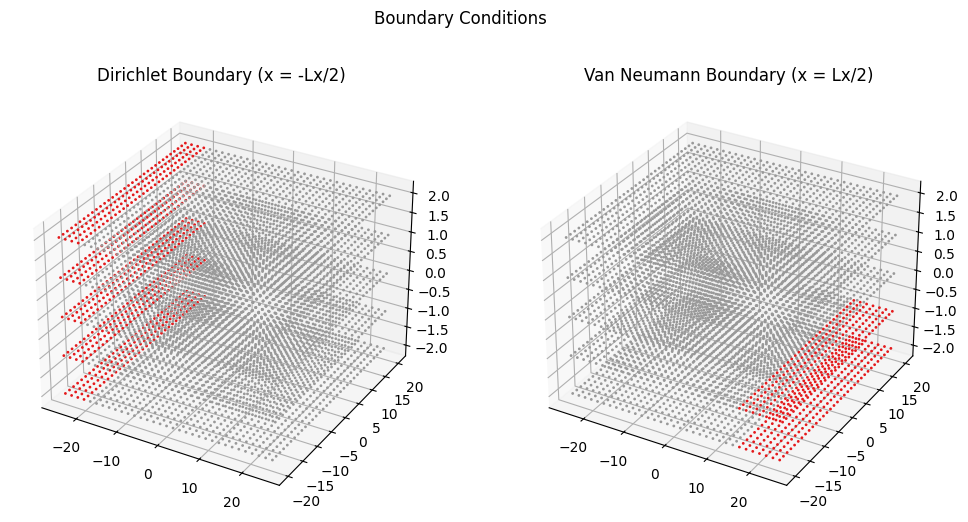

In [59]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 10
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lx / 5),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
colors = jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2)

pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=1,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

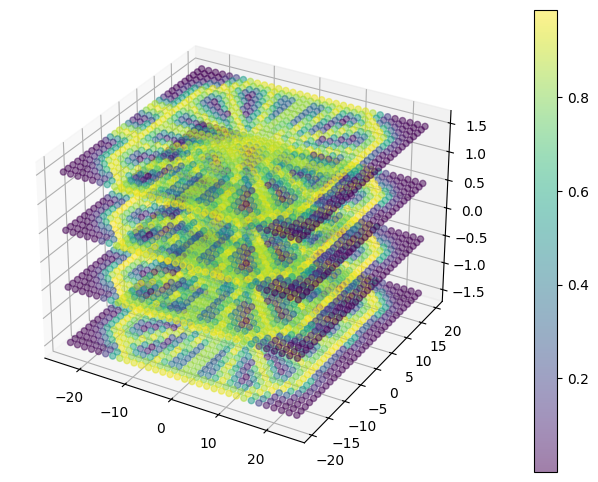

In [60]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [61]:
fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [15]:
# compliance = apply_tesseract(
#     fem_tess,
#     {
#         "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
#         "hex_mesh": adaptive_mesh,
#         "dirichlet_mask": dirichlet_mask,
#         "dirichlet_values": jnp.array([0.0]),
#         "van_neumann_mask": van_neumann_mask,
#         "van_neumann_values": jnp.array([[0.0, 0.0, 10.0]]),
#     },
# )["compliance"]
# print(f"Compliance: {compliance:.4f}")

In [62]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)

In [17]:
# def loss(
#     cell_values: jnp.ndarray,
#     mesh: dict,
# ) -> float:
#     """Compute structural compliance for given bar parameters.

#     Args:
#         cell_values: Material density values for each mesh cell.
#         mesh: Mesh dictionary.

#     Returns:
#         Structural compliance (scalar). Lower values indicate better performance.
#     """
#     mesh = stop_grads_int(mesh)

#     dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

#     van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
#     dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
#     dirichlet_values = jnp.array([0.0])
#     van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

#     # Instead of passing all inputs and trying to stop_gradient on them,
#     # we need to wrap the tesseract call to only allow gradients w.r.t. rho
#     c = apply_tesseract(
#         fem_tess,
#         {
#             "rho": cell_values,
#             "hex_mesh": mesh,
#             "dirichlet_mask": dirichlet_mask,
#             "dirichlet_values": dirichlet_values,
#             "van_neumann_mask": van_neumann_mask,
#             "van_neumann_values": van_neumann_values,
#         },
#     )["compliance"]

#     return c

In [18]:
# # get the gradient of the loss w.r.t. rho
# grad_loss = jax.grad(loss)
# grad = grad_loss(
#     jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1), adaptive_mesh
# )
# print("Grad shape:", grad.shape)

In [19]:
# # print a 3D point cloud of the gradient field
# fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(8, 8))
# pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
# hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
# voxel_center_points = jnp.mean(pts_coords[hex_cells], axis=1)
# print("Voxel center points shape:", voxel_center_points.shape)
# print(mesher_out["mesh"]["n_faces"])
# sc = ax.scatter(
#     voxel_center_points[:, 0],
#     voxel_center_points[:, 1],
#     voxel_center_points[:, 2],
#     c=grad[: mesher_out["mesh"]["n_faces"], 0],
#     cmap="viridis",
#     alpha=1.0,
# )
# # lets add a colorbar
# plt.colorbar(sc, ax=ax, label="Gradient of Compliance w.r.t. rho")

In [26]:
# max_points = 9000
# max_cells = 9000


# def loss(
#     rho: jnp.ndarray,
# ) -> float:
#     """Compute structural compliance for given bar parameters.

#     Args:
#         rho: Bar parameter array with shape (n_chains, n_nodes, 3).

#     Returns:
#         Structural compliance (scalar). Lower values indicate better performance.
#     """
#     sizing = sizing_field(
#         sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
#     )

#     sizing = jax.lax.stop_gradient(sizing)

#     mesher_out = apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
#             "field_values": rho,
#             "max_subdivision_levels": 5,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )

#     mesh = stop_grads_int(mesher_out["mesh"])

#     dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

#     van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
#     dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
#     dirichlet_values = jnp.array([0.0])
#     van_neumann_values = jnp.array([[0.0, 0.0, 10.0]])

#     # Instead of passing all inputs and trying to stop_gradient on them,
#     # we need to wrap the tesseract call to only allow gradients w.r.t. rho
#     c = apply_tesseract(
#         fem_tess,
#         {
#             "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
#             "hex_mesh": mesh,
#             "dirichlet_mask": dirichlet_mask,
#             "dirichlet_values": dirichlet_values,
#             "van_neumann_mask": van_neumann_mask,
#             "van_neumann_values": van_neumann_values,
#         },
#     )["compliance"]

#     return c

In [27]:
# # get grads of loss w.r.t. rho
# grad_loss = jax.grad(loss)
# print(rho.shape)
# grad = grad_loss(rho)

In [28]:
# # plot the grad field
# plot_grid(grad, Lx, Ly, Lz, Nx, Ny, Nz)
# print("Grad min:", jnp.min(grad), "Grad max:", jnp.max(grad))

In [63]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [69]:
@jax.custom_gradient
def gradient_clipping(x):
    return x, lambda g: (jnp.clip(g, -1.0, 1.0))

In [ ]:
max_points = 9000
max_cells = 9000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Geometry parameter array.
        iteration: Current iteration number.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    sdf = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )

    sdf = design_out["sdf"]

    sdf = gradient_clipping(sdf)

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )

    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            # "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "sizing_field": jnp.ones_like(sdf) * sizing_min,
            "field_values": rho_grid,
            "max_subdivision_levels": 5,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    print(rho_cell)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, Lz]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    # lets store all intermediate results in a dictionary to return
    # for visualization purposes
    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    print(
        f"max points : {mesher_out['mesh']['n_points']}, max cells: {mesher_out['mesh']['n_faces']}"
    )

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "rho_cell": rho_cell,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [ ]:
import optax

n_steps = 10
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.01, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adamw(learning_rate=schedule)

params = init_diffable_params.copy()
opt_state = optmizer.init(params)

# params = normalize(init_diffable_params.copy(), normalization_factors)
loss_hist = []
params_hist = []

grad_fn = jax.value_and_grad(loss, has_aux=True)

aux_hist = []

for i in range(n_steps):
    print(params)
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    aux_hist.append(aux)

    print(grads)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    params = params.at[..., 0].set(init_diffable_params[..., 0])  # fix x-coordinates

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.2f}")

[0.4        0.4        0.         0.49999997 0.0621019  0.56210184
 0.12579617 0.62579614 0.18789807 0.68789804 0.24999999 0.74999994
 0.3121019  0.81369424 0.37579614 0.8757961  0.43789804 0.937898  ]


In [72]:
print(grad_storage.keys())

dict_keys([3000, 2000, 1000, 3001, 2001, 1001, 3002, 2002, 1002])


In [73]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    print(mesh["rho"].shape)
    print(rho_dot.shape)
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

(4096,)
(4096,)
(4096,)
(4096,)
(4096,)
(4096,)


In [73]:
# store intermediate grads as vtks

hex_to_pyvista(pts_np, cells_np, {"rho": mesher_out["mesh_cell_values"]})

UnstructuredGrid (0x737f4aabd060)
  N Cells:    40000
  N Points:   40000
  X Bounds:   -2.500e+01, 2.500e+01
  Y Bounds:   -2.000e+01, 2.000e+01
  Z Bounds:   -2.000e+00, 2.000e+00
  N Arrays:   1

Text(0.5, 1.0, 'Compliance over Optimization')

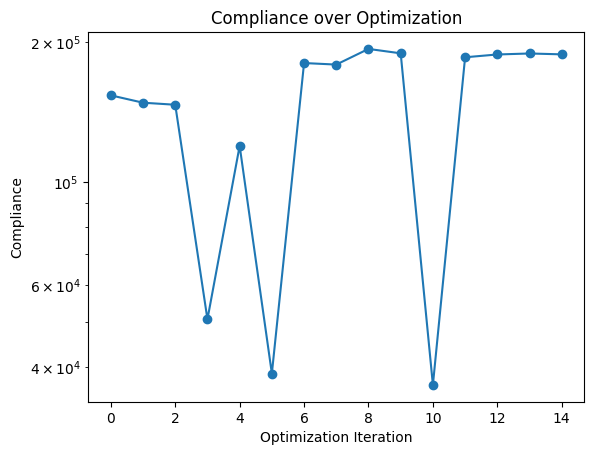

In [77]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [150]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=2).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_optim_sum_2.gif", writer="pillow", fps=10)

In [147]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")